# Exercise 2
Ofri Nussel <br>
Tomer Blumental <br>
Netta Cohen <br>
Asaf Sofer <br>
Yael Keller

In this assignment, we were tasked with analyzing dialogue datasets from two popular sitcoms, 'Friends' and 'Seinfeld.' The goal was to create a model that could identify whether a line was taken from a Seinfeld episode or a Friends episode. <br>
We will start by exploring the data, preprocessing, and then we will build a deep learning model.

## Importing packages and loading the data

In [60]:
# import packages
import pandas as pd
from bs4 import BeautifulSoup
import re
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from nltk.tokenize.toktok import ToktokTokenizer
from math import sqrt
from tqdm.notebook import tqdm
tqdm.pandas()
from wordcloud import WordCloud
from collections import Counter
import time
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [61]:
train_df = pd.read_csv('https://raw.githubusercontent.com/odedovadia/AdvancedMLDLCourse/main/Assignments/Assignment%20II%20-%20NLP/train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/odedovadia/AdvancedMLDLCourse/main/Assignments/Assignment%20II%20-%20NLP/test.csv')

## Visualizations

In [62]:
train_df['Show'].value_counts()

Friends     39092
Seinfeld    31313
Name: Show, dtype: int64

The data is unbalanced, we will balanced it going forward. <br>
Let's plot the distribution of the dialouges in each show.

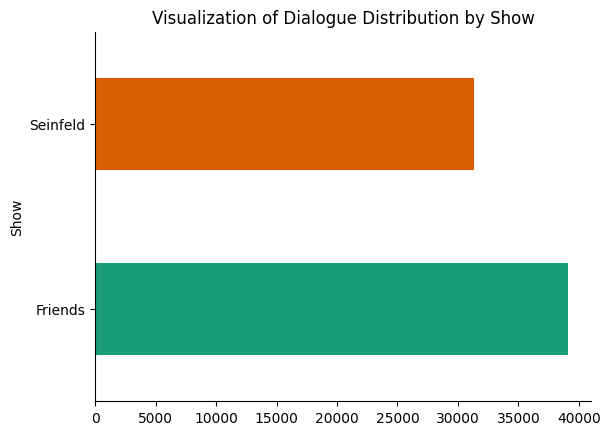

In [63]:
# Show plotting

plt.title("Visualization of Dialogue Distribution by Show")
train_df.groupby('Show').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [64]:
# How many characters are there
len(train_df['Character'].value_counts())

10

There are 10 charcters in all the dataset, we will check how many for each show.

In [65]:
characters_per_show = train_df.groupby('Show')['Character'].nunique()

for show, count in characters_per_show.items():
    print(f"Number of characters in {show}: {count}")

Number of characters in Friends: 6
Number of characters in Seinfeld: 4


In [66]:
# Group characters by show
characters_by_show = train_df.groupby('Show')['Character'].unique()

# Print the names of characters in each show
for show, characters in characters_by_show.items():
    print(f"Characters in {show}: {', '.join(characters)}")

Characters in Friends: joey, phoebe, chandler, monica, ross, rachel
Characters in Seinfeld: elaine, kramer, george, jerry


Next, we will check the length of each dialouge.


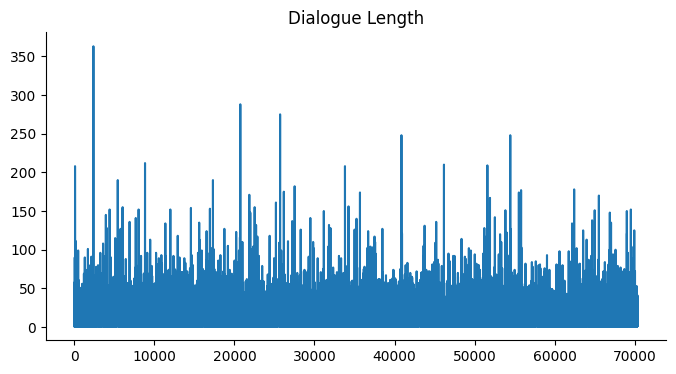

In [67]:
# Dialogue length plotting

from matplotlib import pyplot as plt
train_df['Dialogue_length'].plot(kind='line', figsize=(8, 4), title='Dialogue Length')
plt.gca().spines[['top', 'right']].set_visible(False)

Now we will check the number of lines that each character has in each show.






<ipython-input-68-3a04cdf1919a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Character', order=Character_per_rank[:], palette='muted', data=data_for_count_plot)


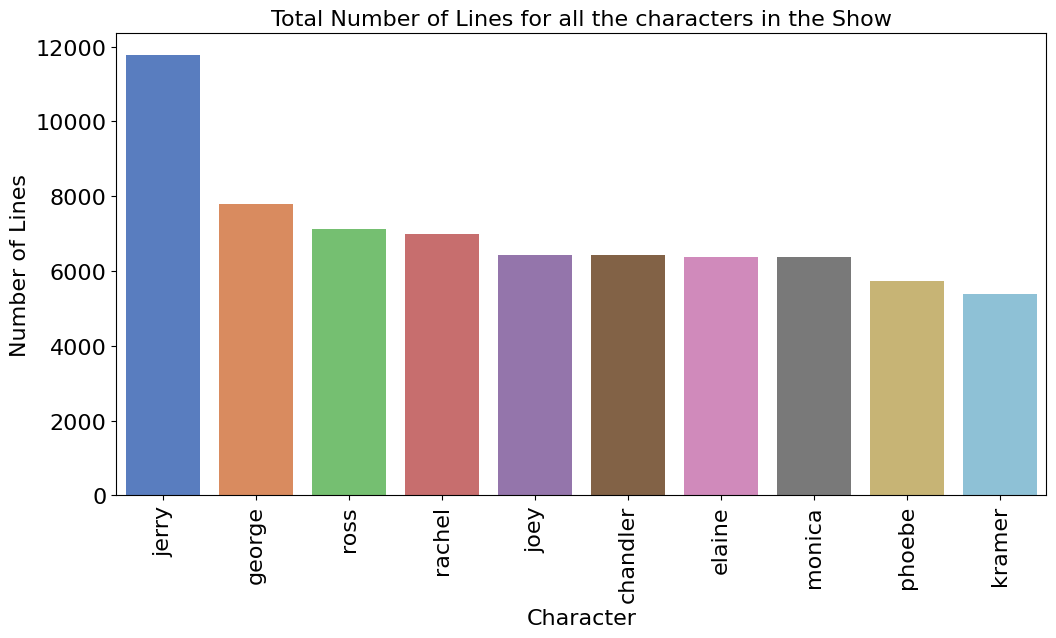

In [68]:
Character_per_rank = train_df['Character'].value_counts().index
data_for_count_plot = train_df[train_df['Character'].isin(Character_per_rank[0:])]

plt.figure(figsize=(12, 6))
sns.countplot(x='Character', order=Character_per_rank[:], palette='muted', data=data_for_count_plot)
plt.xlabel("Character", fontsize=16)
plt.ylabel("Number of Lines", fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.title("Total Number of Lines for all the characters in the Show", fontsize=16)
plt.show()


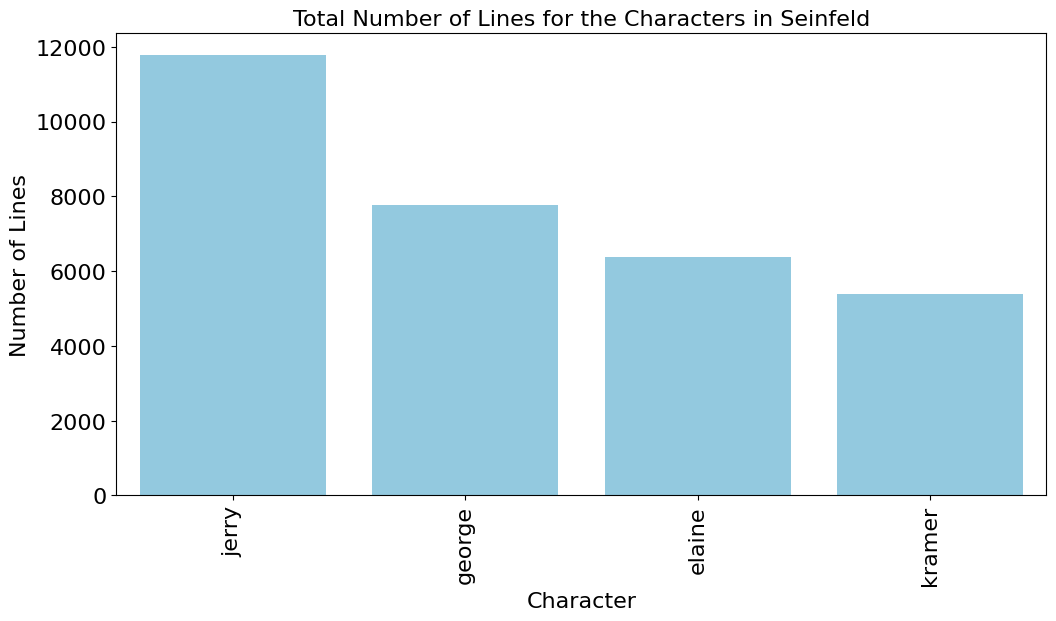

In [69]:
# Filter data for Seinfeld
seinfeld_data = train_df[train_df['Show'] == 'Seinfeld']
seinfeld_character_per_rank = seinfeld_data['Character'].value_counts().index[:15]

plt.figure(figsize=(12, 6))
sns.countplot(x='Character', order=seinfeld_character_per_rank, color='skyblue', data=seinfeld_data)
plt.xlabel("Character", fontsize=16)
plt.ylabel("Number of Lines", fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.title("Total Number of Lines for the Characters in Seinfeld", fontsize=16)
plt.show()

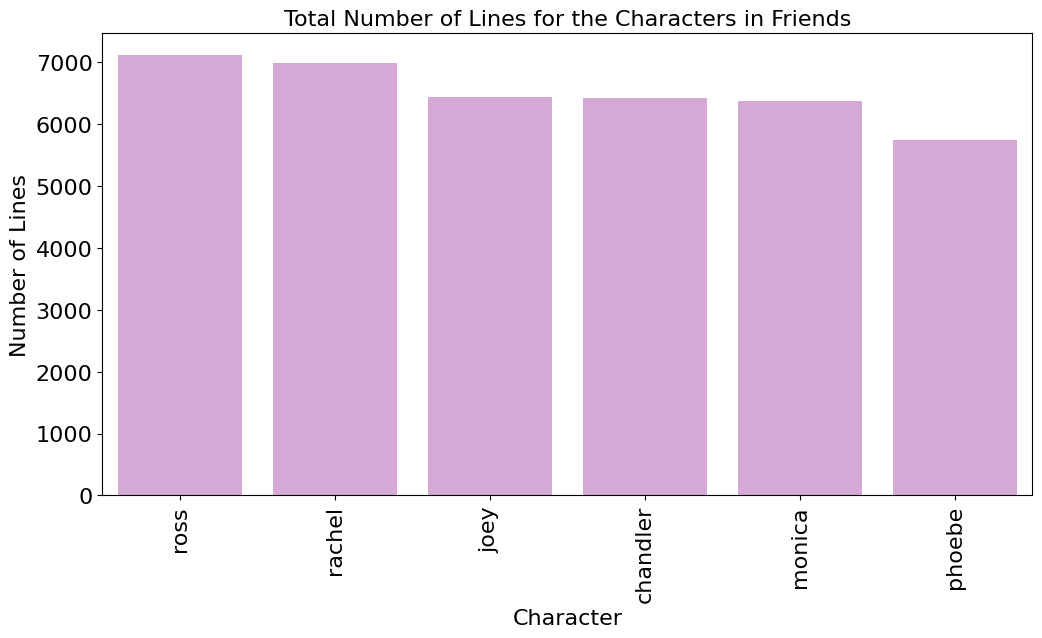

In [70]:
# Filter data for Friends
friends_data = train_df[train_df['Show'] == 'Friends']
friends_character_per_rank = friends_data['Character'].value_counts().index[:15]

plt.figure(figsize=(12, 6))
sns.countplot(x='Character', order=friends_character_per_rank, color='plum', data=friends_data)
plt.xlabel("Character", fontsize=16)
plt.ylabel("Number of Lines", fontsize=16)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.title("Total Number of Lines for the Characters in Friends", fontsize=16)
plt.show()

We assume that it will be easier to correctly classifying Seinfeld vs. Friends lines for Jerry and George from Seinfeld for Seinfeld and for Ross and Rachel for Friends lines beacuse they have more lines for the machine to practice on and to understand which show they relates to. <br>
We will check it after creating the model.

## Preprocessing

### Remove special characters

In [71]:
train_df['Dialogue']

0                                                     Hey.
1         (to Joey) Are you gonna be embarrassed going ...
2        Me? No no no, you. You're gonna tell him. I'm ...
3         Alright you guys are off to party number one ...
4        Am I? Or am I so sane that you just blew your ...
                               ...                        
70400                                         Pretty much.
70401     Oh, well um, not right now. Y'know I’m just g...
70402                  Ooh, I think I wanna trade circles.
70403        Hey, hey, what is this? What's going on here?
70404                                  I want the massage!
Name: Dialogue, Length: 70405, dtype: object

In [72]:
# Define function for removing special characters
def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

# Apply function on review column
train_df['Dialogue'] = train_df['Dialogue'].apply(remove_special_characters)
train_df['Dialogue']

0                                                      Hey
1         to Joey Are you gonna be embarrassed going up...
2        Me No no no you Youre gonna tell him Im not go...
3         Alright you guys are off to party number one ...
4        Am I Or am I so sane that you just blew your mind
                               ...                        
70400                                          Pretty much
70401     Oh well um not right now Yknow Im just gonna ...
70402                    Ooh I think I wanna trade circles
70403             Hey hey what is this Whats going on here
70404                                   I want the massage
Name: Dialogue, Length: 70405, dtype: object

### Remove stopwords

In [73]:
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
print('Number of English stop words:', len(stopword_list))
print(stopword_list[:])

Number of English stop words: 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'onl

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [74]:
def remove_stopwords(text, is_lower_case=False):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# Apply function on review column
train_df['Dialogue'] = train_df['Dialogue'].progress_apply(remove_stopwords)
train_df['Dialogue']

  0%|          | 0/70405 [00:00<?, ?it/s]

0                                                      Hey
1            Joey gonna embarrassed going nothing prepared
2                       Youre gonna tell Im gonna tell Noo
3        Alright guys party number one ushers 3 guys Mo...
4                                           sane blew mind
                               ...                        
70400                                          Pretty much
70401    Oh well um right Yknow Im gonna go bed think f...
70402                        Ooh think wanna trade circles
70403                                  Hey hey Whats going
70404                                         want massage
Name: Dialogue, Length: 70405, dtype: object

### Stemming the text

In [75]:
# Stemming the text
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text
# Apply function on review column
train_df['Dialogue'] = train_df['Dialogue'].progress_apply(simple_stemmer)
train_df['Dialogue']

  0%|          | 0/70405 [00:00<?, ?it/s]

0                                                      hey
1                      joey gonna embarrass go noth prepar
2                        your gonna tell im gonna tell noo
3        alright guy parti number one usher 3 guy monic...
4                                           sane blew mind
                               ...                        
70400                                          pretti much
70401    oh well um right yknow im gonna go bed think f...
70402                          ooh think wanna trade circl
70403                                      hey hey what go
70404                                          want massag
Name: Dialogue, Length: 70405, dtype: object

###Remove short dialogues


We think that short dialogues might confuse the model and will not add value. After several attempts of the amount of characters to remove, we decided to remove dialogues that are shorter than 15 characters.

In [76]:
min_dialogue_length = 15

# Filter out short dialogues from the train_df DataFrame
train_df_filtered = train_df[train_df['Dialogue'].str.len() >= min_dialogue_length]

# Optionally, you can check the number of samples removed
short_removed = len(train_df) - len(train_df_filtered)
print(f'Short dialogues removed: {short_removed}')


Short dialogues removed: 25978


In [77]:
train_df_filtered['Show'].value_counts()

Friends     25601
Seinfeld    18826
Name: Show, dtype: int64

###Balance the data


As we mentioned before, we will balance the data by removing dialouges from 'Friends' randomly.

In [78]:


friends_indices = train_df_filtered.index[train_df_filtered['Show'] == 'Friends']

indices_to_remove = np.random.choice(friends_indices, 6775, replace=False)

# Remove selected samples from the DataFrame
train_df_filtered = train_df_filtered.drop(indices_to_remove)

Sanity check that the data is balanced:

In [79]:
train_df_filtered['Show'].value_counts()

Friends     18826
Seinfeld    18826
Name: Show, dtype: int64

### Word Clouds

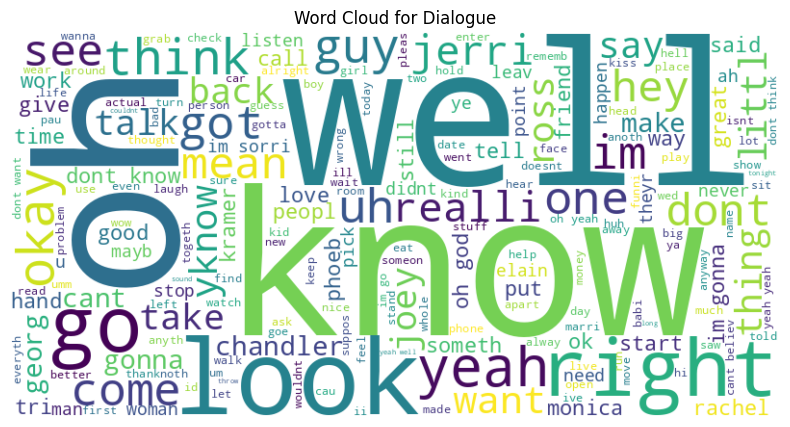

In [80]:
# Extract text data from the 'Dialogue' column in the DataFrame
dialogue_text = ' '.join(train_df_filtered['Dialogue'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(dialogue_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Dialogue')
plt.show()

In [81]:
# Tokenize the text into words
words = ' '.join(train_df_filtered['Dialogue']).split()

# Count the occurrences of each word
word_counts = Counter(words)

# Sort the words by frequency and select the top 40
top_40_words = word_counts.most_common(40)

# Print the top 20 most frequent words
for word, count in top_40_words:
    print(f'{word}: {count}')


im: 4815
oh: 4700
know: 4632
well: 4028
dont: 3722
yeah: 3560
get: 3537
go: 3529
like: 3175
look: 2830
right: 2802
think: 2470
okay: 2400
your: 2277
that: 2236
hey: 2234
gonna: 2106
see: 2032
want: 2010
got: 1975
uh: 1874
come: 1842
realli: 1839
guy: 1804
one: 1758
mean: 1535
cant: 1510
back: 1486
jerri: 1384
say: 1320
take: 1305
tell: 1304
good: 1271
he: 1250
thing: 1213
would: 1203
make: 1183
time: 1146
yknow: 1139
ill: 1132


<ipython-input-82-0c978dd94311>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seinfeld_dialogue_text = ' '.join(train_df_filtered[train_df['Show'] == 'Seinfeld']['Dialogue'])


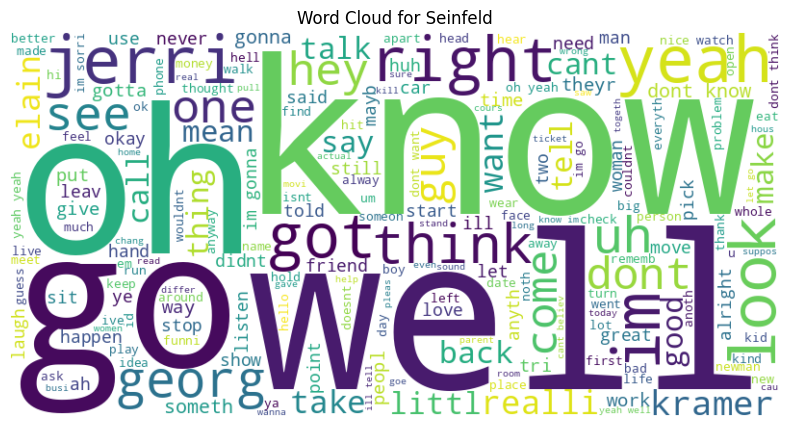

In [82]:
# Filter dialogue text for Seinfeld
seinfeld_dialogue_text = ' '.join(train_df_filtered[train_df['Show'] == 'Seinfeld']['Dialogue'])

# Generate the word cloud for Seinfeld
seinfeld_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(seinfeld_dialogue_text)

# Display the word cloud for Seinfeld
plt.figure(figsize=(10, 5))
plt.imshow(seinfeld_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Seinfeld')
plt.show()

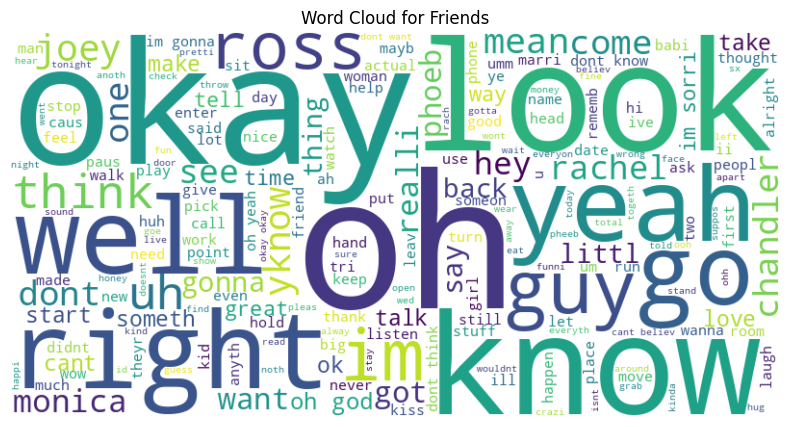

In [83]:
# Filter dialogue text for Friends
friends_dialogue_text = ' '.join(train_df_filtered[train_df_filtered['Show'] == 'Friends']['Dialogue'])

# Generate the word cloud for Friends
friends_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(friends_dialogue_text)

# Display the word cloud for Friends
plt.figure(figsize=(10, 5))
plt.imshow(friends_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Friends')
plt.show()


  Using this plots of the word cloud, we will remove words that repeats in both models because we think this word will make the accuracy low.

### Remove common words in both of the shows

In [84]:
# Filter dialogue text for Seinfeld
seinfeld_dialogue_text = ' '.join(train_df_filtered[train_df_filtered['Show'] == 'Seinfeld']['Dialogue'])

# Tokenize the text into words for Seinfeld
seinfeld_words = seinfeld_dialogue_text.split()

# Count the occurrences of each word for Seinfeld
seinfeld_word_counts = Counter(seinfeld_words)

# Sort the words by frequency and select the top 10 for Seinfeld
seinfeld_top_10_words = seinfeld_word_counts.most_common(10)

# Print the top 10 most frequent words for Seinfeld
print("Top 10 words for Seinfeld:")
for word, count in seinfeld_top_10_words:
    print(f'{word}: {count}')

# Filter dialogue text for Friends
friends_dialogue_text = ' '.join(train_df_filtered[train_df_filtered['Show'] == 'Friends']['Dialogue'])

# Tokenize the text into words for Friends
friends_words = friends_dialogue_text.split()

# Count the occurrences of each word for Friends
friends_word_counts = Counter(friends_words)

# Sort the words by frequency and select the top 10 for Friends
friends_top_10_words = friends_word_counts.most_common(10)

# Print the top 10 most frequent words for Friends
print("\nTop 10 words for Friends:")
for word, count in friends_top_10_words:
    print(f'{word}: {count}')


Top 10 words for Seinfeld:
know: 2416
im: 2289
well: 2121
go: 1833
oh: 1825
dont: 1808
yeah: 1772
get: 1748
like: 1647
jerri: 1382

Top 10 words for Friends:
oh: 2875
im: 2526
know: 2216
okay: 2075
dont: 1914
well: 1907
get: 1789
yeah: 1788
go: 1696
look: 1687


In [85]:
def remove_common_words(df):
    for index, row in df.iterrows():
        df.loc[index, 'Dialogue'] = row['Dialogue'].replace('im', '')
        df.loc[index, 'Dialogue'] = row['Dialogue'].replace('oh', '')
        df.loc[index, 'Dialogue'] = row['Dialogue'].replace('yeah', '')
        df.loc[index, 'Dialogue'] = row['Dialogue'].replace('well', '')
        df.loc[index, 'Dialogue'] = row['Dialogue'].replace('go', '')
        df.loc[index, 'Dialogue'] = row['Dialogue'].replace('dont', '')
        df.loc[index, 'Dialogue'] = row['Dialogue'].replace('get', '')
        df.loc[index, 'Dialogue'] = row['Dialogue'].replace('know', '')

    return df

In [86]:
train_df_filtered=remove_common_words(train_df_filtered)


### Train and Test split

In [87]:
X = train_df_filtered['Dialogue']
Y = train_df_filtered['Show']

In [88]:
x_test=test_df['Dialogue']
y_test=test_df['Show']

In [89]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [90]:
train_label_count = y_train.value_counts()
test_label_count = y_val.value_counts()

print('Train Friends to Seinfeld ratio:', train_label_count['Friends'] / train_label_count['Seinfeld'])
print('Test Friends to Seinfeld ratio:', test_label_count['Friends'] / test_label_count['Seinfeld'])

Train Friends to Seinfeld ratio: 0.9947682119205298
Test Friends to Seinfeld ratio: 1.021202361782072


In [91]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)

x_train shape: (30121,)
y_train shape: (30121,)
x_test shape: (4245,)
y_test shape: (4245,)
x_val shape: (7531,)
y_val shape: (7531,)


## Deep Learning Model- NN

In [92]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_val = lb.transform(y_val)

Lables:
1- friends
0- Seinfeld

Import packages for deep learning model

In [93]:
from keras.models import Sequential
from keras.layers import Dropout, Conv1D, Flatten, Dense, Embedding
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

In [94]:
# Initialize the Tokenizer
token = Tokenizer(lower=False)
# Fit the tokenizer on the training data
token.fit_on_texts(x_train)

In [95]:
x_train_dl = token.texts_to_sequences(x_train)
x_val_dl = token.texts_to_sequences(x_val)
#x_test_dl = token.texts_to_sequences(x_test)לא לשכוח להוסיף לתהליך על הטסט

In [96]:
x_train_dl[10]

[5, 830, 231]

Find the range of the dialouges

In [97]:
doc_len_list = [len(doc) for doc in x_train_dl]
max(doc_len_list), min(doc_len_list), np.mean(doc_len_list)

(177, 1, 8.128813784402908)

Plot the dialouges length in order to make the dialouges in the same length for the deep learning model.

<Axes: ylabel='Count'>

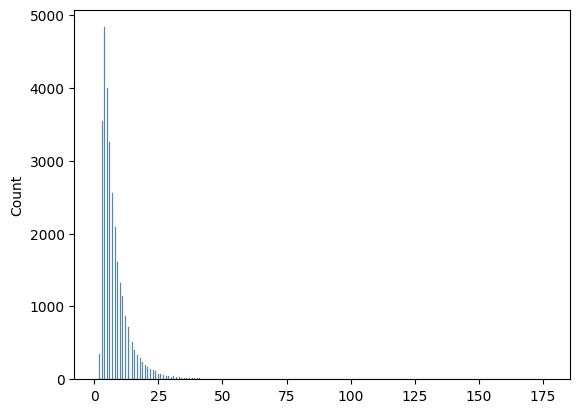

In [98]:
sns.histplot(doc_len_list)

We decided that 45 would be good cutoff.

In [99]:
max_words = 45

x_train_dl = sequence.pad_sequences(x_train_dl, maxlen=max_words)
x_val_dl = sequence.pad_sequences(x_val_dl, maxlen=max_words)

In [100]:
x_train_dl[0, :]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,   83,    7,
       1810], dtype=int32)

In [101]:
total_words = len(token.word_index) + 1
total_words

13966

Now we will run the standard model of deep learning for text and check the results.

In [102]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=50, input_length=max_words))
model.add(Conv1D(8, 3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 45, 50)            698300    
                                                                 
 conv1d_1 (Conv1D)           (None, 45, 8)             1208      
                                                                 
 flatten_1 (Flatten)         (None, 360)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                23104     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 722677 (2.76 MB)
Trainable params: 72267

In [103]:
model.fit(x_train_dl, y_train, validation_data=(x_val_dl, y_val), epochs=5, batch_size=64)

Epoch 1/5
471/471 [==============================] - 16s 31ms/step - loss: 0.5409 - accuracy: 0.7002 - val_loss: 0.4342 - val_accuracy: 0.7806
Epoch 2/5
471/471 [==============================] - 3s 7ms/step - loss: 0.3726 - accuracy: 0.8222 - val_loss: 0.4317 - val_accuracy: 0.7794
Epoch 3/5
471/471 [==============================] - 3s 6ms/step - loss: 0.2865 - accuracy: 0.8687 - val_loss: 0.4689 - val_accuracy: 0.7761
Epoch 4/5
471/471 [==============================] - 3s 7ms/step - loss: 0.2206 - accuracy: 0.9014 - val_loss: 0.5536 - val_accuracy: 0.7672
Epoch 5/5
471/471 [==============================] - 3s 7ms/step - loss: 0.1736 - accuracy: 0.9255 - val_loss: 0.6463 - val_accuracy: 0.7601


The accuracy on the val dataset is less then 80% but very close.  <br>
We made a few changes on the standard deep learning model but all the results were lower or the same, so we stayed with the standard model.

## Preprocessing and testing the test set

We will implement the preprocessing on the test data, and then we will run the model on it.

In [104]:
test_df['Dialogue'] = test_df['Dialogue'].apply(remove_special_characters)
test_df['Dialogue'] = test_df['Dialogue'].progress_apply(remove_stopwords)
test_df['Dialogue'] = test_df['Dialogue'].progress_apply(simple_stemmer)
test_df = remove_common_words(test_df)

x_test=test_df['Dialogue']
y_test=test_df['Show']
y_test = lb.transform(y_test)

  0%|          | 0/4245 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

In [105]:
x_test_dl = token.texts_to_sequences(x_test)
x_test_dl = sequence.pad_sequences(x_test_dl, maxlen=max_words)

In [106]:
result = model.evaluate(x_test_dl, y_test)
result

133/133 [==============================] - 0s 2ms/step - loss: 0.6002 - accuracy: 0.8186


[0.6001982092857361, 0.8186101317405701]

The score is greater then 80% !

## Evaluate the model on each character

First, we will build a function that will help us build the plot to evaluate the model on each character.

In [107]:
from sklearn.metrics import accuracy_score

predictions = model.predict(x_test_dl)

# Convert predictions to binary labels (0 or 1)
predicted_labels = (predictions > 0.5).astype(int)

# Ensure y_test is a 1D array
y_test = y_test.flatten()

# Calculate accuracy score
accuracy = accuracy_score(y_test, predicted_labels.flatten())

# Print or store the accuracy score
print(f'Accuracy Score: {accuracy}')

# Create a DataFrame with real and predicted labels
results_df = pd.DataFrame({
    'Real_Labels': y_test,
    'Predicted_Labels': predicted_labels.flatten(),
    'Charecter': test_df['Character']
})

133/133 [==============================] - 0s 2ms/step
Accuracy Score: 0.8186101295641932


Next, we will plot the results

      Real_Labels  Predicted_Labels Charecter
0               0                 0      joey
1               0                 0    monica
2               1                 0    george
3               1                 1    kramer
4               0                 1    monica
...           ...               ...       ...
4240            0                 0      joey
4241            0                 0    rachel
4242            0                 0      ross
4243            1                 1    kramer
4244            1                 1     jerry

[4245 rows x 3 columns]
Accuracy for joey: 0.826271186440678
Accuracy for monica: 0.8507853403141361
Accuracy for george: 0.7869198312236287
Accuracy for kramer: 0.793918918918919
Accuracy for rachel: 0.8636363636363636
Accuracy for ross: 0.8421052631578947
Accuracy for phoebe: 0.850253807106599
Accuracy for jerry: 0.7955706984667802
Accuracy for chandler: 0.7907542579075426
Accuracy for elaine: 0.773972602739726


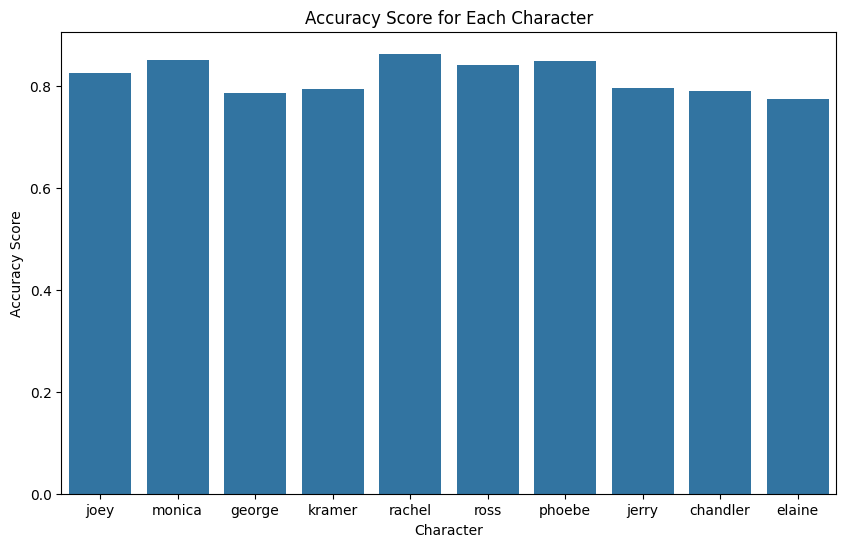

In [108]:
print(results_df)

# Get all unique character names as a list
characters = results_df['Charecter'].unique().tolist()


# Create a dictionary to store accuracy scores for each character
accuracy_scores = {}

# Loop through each character and calculate accuracy
for character in characters:
    # Filter the DataFrame for the current character
    character_df = results_df[results_df['Charecter'] == character]

    # Calculate accuracy score
    accuracy = accuracy_score(character_df['Real_Labels'], character_df['Predicted_Labels'])

    # Store the accuracy score in the dictionary
    accuracy_scores[character] = accuracy

    # Print or visualize the results as needed
    print(f'Accuracy for {character}: {accuracy}')

# Plot and visualize the results
plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()))
plt.xlabel('Character')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score for Each Character')
plt.show()


In [109]:


# Your DataFrame creation
results = {'test set accuracy': [f'{result[1]}'],
           'train set accuracy': ['0.7821'],
           'Number of trainable parameters': ['722677'],
           'Number of layers': ['6'],
           'Regularization methods': ['dropout'],
           'Number of epochs': ['5'],
           'Choice of optimizer': ['Adam'],
           'Embedding dimension': ['50']
           }

results_csv = pd.DataFrame(results)

# Mount Google Drive
drive.mount('/content/drive')

# Specify the directory path
path_to_save = '/content/drive/My Drive/Colab Notebooks/EX_2'

# Create the directory if it doesn't exist
os.makedirs(path_to_save, exist_ok=True)

# Save the DataFrame as a CSV file
results_csv.to_csv(os.path.join(path_to_save, 'EX_2.csv'), index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
